# Lightning.gpu: cuQuantum-Accelerated Quantum Machine Learning Simulations in Pennylane

In this tutorial, we'll see how to use lightning.gpu, which is a cuQuantum-accelerated state vector simulator available in Xanadu's Pennylane framework. Pennylane is especially well-suited to quantum machine learning applications.  

Quantum computers have the potential to one day dramatically accelerate some machine learning workloads. For now, quantum machine learning is a highly-active research area. Due to the frequent need for long training, quantum machine learning circuits tend to be some of the most difficult and compute-intensive, and can benefit dramatically from GPU acceleration.

The Pennylane page contains a great deal of information and tutorials, and is a great place to start learning more about quantum machine learning: https://pennylane.ai/ 

In this tutorial, we'll first benchmark the cuQuantum GPU simulator against the lightning.qubit fast CPU simulator on a simple example circuit to get a sense of the cuQuantum speedup for QML workloads. Then we'll show how to implement a quantum variational classifier using lightning.gpu. 

## Setup

We'll define two devices with 24 qubits, one using lightning.qubit and the other using lightning.gpu

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [2]:
cpu_device = qml.device("lightning.qubit", wires=24)
cuquantum_device = qml.device("lightning.gpu", wires=24)

/opt/conda/lib/python3.8/site-packages/pennylane_lightning_gpu/lightning_gpu.py:77: UserWarning: CUDA device is an unsupported version: (-146893024, 32685)
  warn(str(e), UserWarning)
/opt/conda/lib/python3.8/site-packages/pennylane_lightning_gpu/lightning_gpu.py:428: RuntimeWarning: 
            !!!#####################################################################################
            !!!
            !!! WARNING: INSUFFICIENT SUPPORT DETECTED FOR GPU DEVICE WITH `lightning.gpu`
            !!!          DEFAULTING TO CPU DEVICE `lightning.qubit`
            !!!
            !!!#####################################################################################
            
  warn(


Now we'll create a qnode, which defines a quantum object in Pennylane. We'll start by defining a qnode with the lightning.qubit simulator device. For the actual circuit we'll use a single StronglyEntanglingLayer, followed by an expectation value on Pauli Z for each qubit. This is a very simple circuit but represents fundamental building blocks of a quantum machine learning algorithm. You can read more about the StronglyEntanglingLayer function here: https://pennylane.readthedocs.io/en/latest/code/api/pennylane.StronglyEntanglingLayers.html

In [9]:
@qml.qnode(cpu_device, diff_method="adjoint")
def circuit(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(24))
    return [qml.expval(qml.PauliZ(i)) for i in range(24)]

In [10]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=24)
weights = qml.numpy.random.random(size=shape)

## CPU Simulation

Now we'll simulate the circuit and measure the execution time. Even though this circuit is simple, the simulation is compute-intensive and this cell will take about 1-2 minutes to execute on the CPU. While it is running, you can read about the recent integration of lightning.gpu as an embedded simulator in Amazon Braket here: https://aws.amazon.com/blogs/quantum-computing/using-embedded-simulators-in-amazon-braket-hybrid-jobs/. By combining the lightning.gpu acceleration with parallelization over multiple nodes, users can achieve in the neighborhood of a 900x speedup on QML workloads, at 3.5x less cost than running the same job on a CPU.

In [ ]:
%time jac = qml.jacobian(circuit)(weights)
f"device={cpu_device.short_name}, qubits={24}, trainable_params={len(circuit.tape.trainable_params)}"

## GPU Simulation with cuQuantum

Now, let's run the exact same experiment, but using the cuQuantum device with lightning.gpu. You should see a >5x speedup just from switching the simulator. Generally this speedup will be even more dramatic as the size of the device or the depth of the circuit is increased. 

In [ ]:
@qml.qnode(cuquantum_device, diff_method="adjoint")
def circuit(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(24))
    return [qml.expval(qml.PauliZ(i)) for i in range(24)]

%time jac = qml.jacobian(circuit)(weights)
f"device={cuquantum_device.short_name}, qubits={24}, trainable_params={len(circuit.tape.trainable_params)}"

## Implementing a Variational Classifier with lightning.gpu

Now let's use lightning.gpu to solve a real problem, implementing a variational quantum classifier - a quantum circuit that can be trained from labelled data to classify new data samples.

We will show that the variational quantum classifier can reproduce the parity function. This optimization example demonstrates how to encode binary inputs into the initial state of the variational circuit, which is simply a computational basis state.

This part of the tutorial follows the variational classifier tutorial which was developed by the Xanadu team and is available on the Pennylane site: https://pennylane.ai/qml/demos/tutorial_variational_classifier.html

For simplicity, we'll create a new quantum device with 4 qubits:

In [14]:
dev = qml.device("lightning.gpu", wires=4)

Variational classifiers usually define a “layer” or “block”, which is an elementary circuit architecture that gets repeated to build the variational circuit.

Our circuit layer consists of an arbitrary rotation on every qubit, as well as CNOTs that entangle each qubit with its neighbor.

In [15]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

We also need a way to encode data inputs into the circuit, so that the measured output depends on the inputs. In this example, the inputs are bitstrings, which we encode into the state of the qubits using the BasisState function provided by PennyLane.

In [16]:
def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

Now we define the quantum node as a state preparation routine, followed by a repetition of the layer structure. Borrowing from machine learning, we call the parameters weights.

In [17]:
@qml.qnode(dev)
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

The quantum node takes the data as a keyword argument x (with the default value None). Keyword arguments of a quantum node are considered as fixed when calculating a gradient; they are never trained.

If we want to add a “classical” bias parameter, the variational quantum classifier also needs some post-processing. We define the final model by a classical node that uses the first variable, and feeds the remainder into the quantum node. Before this, we reshape the list of remaining variables for easy use in the quantum node.

In [18]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

## Cost

In supervised learning, the cost function is usually the sum of a loss function and a regularizer. We use the standard square loss that measures the distance between target labels and model predictions.

In [19]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2

    loss /= len(labels)
    return loss

To monitor how many inputs the current classifier predicted correctly, we also define the accuracy given target labels and model predictions.

In [20]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss += 1
    loss /= len(labels)

    return loss

For learning tasks, the cost depends on the data - here the features and labels considered in the iteration of the optimization routine.

In [21]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

## Optimization

Let’s now load and preprocess some data.

In [ ]:
data = np.loadtxt("data/parity.txt")
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

We initialize the variables randomly (but fix a seed for reproducibility). The first variable in the list is used as a bias, while the rest is fed into the gates of the variational circuit.

In [ ]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

Next we create an optimizer and choose a batch size…



In [24]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

…and train the optimizer. We track the accuracy - the share of correctly classified data samples. For this we compute the outputs of the variational classifier and turn them into predictions in {−1,1} by taking the sign of the output.

In [25]:
weights, bias = weights_init, bias_init
data = []
for it in range(25):

    # Update the weights by one optimizer step.
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy.
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    data.append((it+1, cost(weights, bias, X, Y), acc))

Let's plot the accuracy as a function of the iteration:

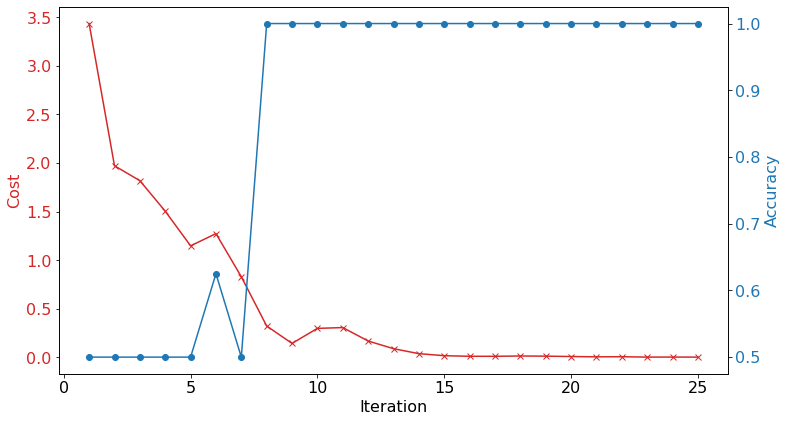

In [26]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 12, 6.75
plt.rcParams['font.size'] = 16
             
it, cost, acc = zip(*data)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cost', color=color)
ax1.plot(it, cost, color=color, marker='x')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(it, acc, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

The accuracy should hit 1 after 5-10 iterations. Congratulations, you've used cuQuantum and lightning.gpu to train a variational classifier! 

Obviously this is a simple example, but you can start experimenting with larger datasets, larger circuits, and more complex problems. Pennylane hosts a large number of demos here to get started: https://pennylane.ai/qml/demos_qml.html

## Afternotes

In this tutorial we explored the cuQuantum-based lightning.gpu simulator now available in Pennylane. We ran a benchmark to see the acceleration compared to the fastest available CPU simulator, and then used lightning.gpu to train a simple variational classifier. 

We encourage you to continue exploring what can be done with lightning.gpu. Quantum machine learning is a nascent field, and there is tremendous opportunity for new research and discovery. 

For more on lightning.gpu see the [documentation](https://pennylane-lightning-gpu.readthedocs.io/en/latest/), as well as their [Github](https://github.com/PennyLaneAI/pennylane-lightning-gpu) repository.

Please refer to the [documentation](https://docs.nvidia.com/cuda/cuquantum/python/index.html) and explore the [samples](https://github.com/NVIDIA/cuQuantum/tree/main/python/samples) on GitHub to learn more about cuQuantum.

